# HW 0


### Here is the reference to the dataset I am using [Alzheimer’s Prediction Dataset (Global)]: https://www.kaggle.com/datasets/ankushpanday1/alzheimers-prediction-dataset-global

### First, we need to load the dataset using pandas DataFrame

In [86]:
import pandas as pd

print("------- LOADING DATASET -------")
print("Reading 'alzheimers_data.csv' into a pandas DataFrame...")
df = pd.read_csv("alzheimers_data.csv")
print("Dataset loaded. Number of rows, columns:", df.shape)

------- LOADING DATASET -------
Reading 'alzheimers_data.csv' into a pandas DataFrame...
Dataset loaded. Number of rows, columns: (74283, 25)


### Now select 10 features from the dataset in addition to the target column

#### Here are the 10 features:
    1) Age (numeric)
    2) Gender (categorical)
    3) Education Level (numeric-ish)
    4) BMI (numeric)
    5) Physical Activity Level (categorical)
    6) Smoking Status (categorical)
    7) Diabetes (categorical)
    8) Hypertension (categorical)
    9) Cholesterol Level (categorical)
    10) Family History of Alzheimer’s (categorical)
    Target: Alzheimer’s Diagnosis (Yes/No)

In [73]:
print("------- SELECTING 10 FEATURES + TARGET -------")

selected_columns = [
        "Age",
        "Gender",
        "Education Level",
        "BMI",
        "Physical Activity Level",
        "Smoking Status",
        "Diabetes",
        "Hypertension",
        "Cholesterol Level",
        "Family History of Alzheimer’s",
        "Alzheimer’s Diagnosis"  # target
    ]

# Subset the DataFrame
df = df[selected_columns].copy()
print("Selected columns:", selected_columns)

------- SELECTING 10 FEATURES + TARGET -------
Selected columns: ['Age', 'Gender', 'Education Level', 'BMI', 'Physical Activity Level', 'Smoking Status', 'Diabetes', 'Hypertension', 'Cholesterol Level', 'Family History of Alzheimer’s', 'Alzheimer’s Diagnosis']


### Encode all categorical features

In [ ]:
print("------- ENCODING CATEGORICAL FEATURES -------")
    # We'll label-encode columns that are categorical:
    # (Gender, Physical Activity Level, Smoking Status,
    #  Diabetes, Hypertension, Cholesterol Level,
    #  Family History of Alzheimer’s, Alzheimer’s Diagnosis)
categorical_cols = [
    "Gender",
    "Physical Activity Level",
    "Smoking Status",
    "Diabetes",
    "Hypertension",
    "Cholesterol Level",
    "Family History of Alzheimer’s",
    "Alzheimer’s Diagnosis"
]
    
label_encoders = {}
for col in categorical_cols:
    print(f"Encoding column: {col}")
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Create separate feature and target arrays
feature_cols = selected_columns[:-1]  # all but the last 
target_col   = selected_columns[-1]   # the last one: "Alzheimer’s Diagnosis"

X = df[feature_cols].values
y = df[target_col].values

print("Feature shape:", X.shape, " | Target shape:", y.shape) # no y-coordinate for shape

------- ENCODING CATEGORICAL FEATURES -------
Encoding column: Gender
Encoding column: Physical Activity Level
Encoding column: Smoking Status
Encoding column: Diabetes
Encoding column: Hypertension
Encoding column: Cholesterol Level
Encoding column: Family History of Alzheimer’s
Encoding column: Alzheimer’s Diagnosis
Feature shape: (74283, 10)  | Target shape: (74283,)


### Create a balanced test set for each class of 100 and leave the rest for training data

In [75]:
import numpy as np

print("------- CREATING BALANCED TEST SET -------")
class0_indices = np.where(y == 0)[0]  # "No"
class1_indices = np.where(y == 1)[0]  # "Yes"

np.random.shuffle(class0_indices)
np.random.shuffle(class1_indices)

# Take 100 from each for test
test_class0 = class0_indices[:100]
test_class1 = class1_indices[:100]

# The remaining for training
train_class0 = class0_indices[100:]
train_class1 = class1_indices[100:]

# Build the train/test sets
test_indices = np.concatenate((test_class0, test_class1))
train_indices = np.concatenate((train_class0, train_class1))
np.random.shuffle(test_indices)
np.random.shuffle(train_indices)

X_test = X[test_indices]
y_test = y[test_indices]
    
X_train_full = X[train_indices]
y_train_full = y[train_indices]

print("Test set size:", len(X_test),
    "| Class 0 in test:", len(test_class0),
    "| Class 1 in test:", len(test_class1))
print("Training set size:", len(X_train_full))

------- CREATING BALANCED TEST SET -------
Test set size: 200 | Class 0 in test: 100 | Class 1 in test: 100
Training set size: 74083


### Unbalance the remaining training data

In [76]:
print("------ UNBALANCING TRAINING DATA ------")
# Suppose we want 43570 from class0 (No) and 30713 from class1 (Yes).
desired_class0 = 43570 
desired_class1 = 30713

# Sample/replicate from our training set as needed
print("Desired class-0 (No) count:", desired_class0)
print("Desired class-1 (Yes) count:", desired_class1)

def get_unbalanced_indices(train_cls_indices, desired_count):
    if len(train_cls_indices) < desired_count:
        # Replicate some
        replicate_factor = (desired_count // len(train_cls_indices)) + 1
        extended = np.tile(train_cls_indices, replicate_factor)
        np.random.shuffle(extended)
        return extended[:desired_count]
    else:
        np.random.shuffle(train_cls_indices)
        return train_cls_indices[:desired_count]

train_class0_bal = get_unbalanced_indices(train_class0, desired_class0)
train_class1_bal = get_unbalanced_indices(train_class1, desired_class1)

unbalanced_train_indices = np.concatenate((train_class0_bal, train_class1_bal))
np.random.shuffle(unbalanced_train_indices)

X_train = X[unbalanced_train_indices]
y_train = y[unbalanced_train_indices]

print("Unbalanced training set size:", len(X_train),
    "| Class 0 in unbalanced set:", sum(y_train == 0),
    "| Class 1 in unbalanced set:", sum(y_train == 1))


------ UNBALANCING TRAINING DATA ------
Desired class-0 (No) count: 43570
Desired class-1 (Yes) count: 30713
Unbalanced training set size: 74283 | Class 0 in unbalanced set: 43570 | Class 1 in unbalanced set: 30713


### Randomly relabel 5% of each class

In [78]:
print("------ FLIPPING 5% OF LABELS IN THE TRAINING SET ------")
def flip_labels(y_array, flip_fraction=0.05):
    idx_class0 = np.where(y_array == 0)[0]
    idx_class1 = np.where(y_array == 1)[0]

    n0 = len(idx_class0)
    n1 = len(idx_class1)

    flip_n0 = int(flip_fraction * n0)  # Flip how many 0 -> 1
    flip_n1 = int(flip_fraction * n1)  # Flip how many 1 -> 0

    flip_indices_0 = np.random.choice(idx_class0, size=flip_n0, replace=False)
    flip_indices_1 = np.random.choice(idx_class1, size=flip_n1, replace=False)

    # Flip them in-place
    y_array[flip_indices_0] = 1
    y_array[flip_indices_1] = 0

    print(f"Flipped {len(flip_indices_0)} '0' labels to '1' and "
        f"{len(flip_indices_1)} '1' labels to '0'.")

flip_labels(y_train, flip_fraction=0.05)

------ FLIPPING 5% OF LABELS IN THE TRAINING SET ------
Flipped 2178 '0' labels to '1' and 1535 '1' labels to '0'.


### Time to build our shallow feed-foward network

In [79]:
from tensorflow import keras
from tensorflow.keras import layers

print("------- BUILDING A SHALLOW FEED-FORWARD NETWORK ------")
# We have 10 input features, use a single hidden layer with 2*input_dim = 20 units.
# Sigmoid activation on hidden layer, and sigmoid on the output layer for binary classification.
input_dim = X_train.shape[1]
hidden_dim = 2 * input_dim  # 2x the number of input features

def build_model():
    """Build and compile a simple 2-layer (1 hidden layer) neural network."""
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    model.add(layers.Dense(hidden_dim, activation='sigmoid'))
    model.add(layers.Dense(1, activation='sigmoid'))  
    model.compile(loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy'])
    return model

print("Model architecture: 10 -> 20 -> 1 (sigmoid activations).")

------- BUILDING A SHALLOW FEED-FORWARD NETWORK ------
Model architecture: 10 -> 20 -> 1 (sigmoid activations).


### Train network 10 times

In [81]:
print("------- TRAINING NETWORK 10 TIMES -------")
num_runs = 10
num_epochs = 20
batch_size = 32

# Record of train/test accuracy each epoch, across runs
train_acc_history = [[] for _ in range(num_epochs)]
test_acc_history  = [[] for _ in range(num_epochs)]

# Number of parameter updates per epoch
updates_per_epoch = len(X_train) // batch_size

# Store log(#updates) on the x-axis for plotting
log_updates_x = []
for epoch_index in range(num_epochs):
    # Cumulative updates 
    total_updates = (epoch_index+1) * updates_per_epoch
    if total_updates == 0:
        total_updates = 1  # avoid log(0)
    log_updates_x.append(np.log(total_updates))

# Train the model multiple times and store accuracy each epoch
print(f"Training details: {num_runs} runs, {num_epochs} epochs each, batch size = {batch_size}")
for run_i in range(num_runs):
    print(f"--- Run {run_i+1}/{num_runs} ---")
    # Build a fresh model
    model = build_model()

    for epoch_i in range(num_epochs):
        # Train for 1 epoch
        model.fit(X_train, y_train,
            epochs=1,
            batch_size=batch_size,
            verbose=0)

        # Evaluate on training set
        train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
        # Evaluate on test set
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

        train_acc_history[epoch_i].append(train_acc)
        test_acc_history[epoch_i].append(test_acc)

# Compute average train/test accuracy at each epoch across the 10 runs
avg_train_acc = [np.mean(acc_list) for acc_list in train_acc_history]
avg_test_acc  = [np.mean(acc_list) for acc_list in test_acc_history]

------- TRAINING NETWORK 10 TIMES -------
Training details: 10 runs, 20 epochs each, batch size = 32
--- Run 1/10 ---
--- Run 2/10 ---
--- Run 3/10 ---
--- Run 4/10 ---
--- Run 5/10 ---
--- Run 6/10 ---
--- Run 7/10 ---
--- Run 8/10 ---
--- Run 9/10 ---
--- Run 10/10 ---


### Plot two curves: average train and test accuracy vs. log

------- PLOTTING RESULT -------


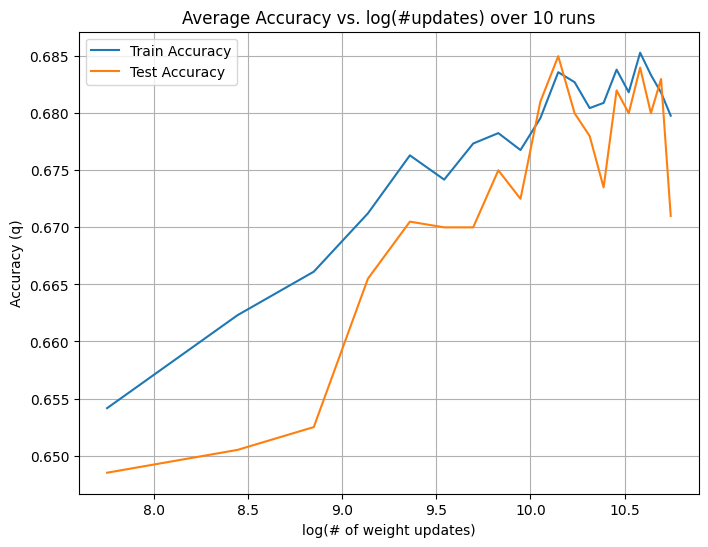

In [82]:
import matplotlib.pyplot as plt

print("------- PLOTTING RESULT -------")
plt.figure(figsize=(8,6))
plt.plot(log_updates_x, avg_train_acc, label="Train Accuracy")
plt.plot(log_updates_x, avg_test_acc, label="Test Accuracy")
plt.xlabel("log(# of weight updates)")
plt.ylabel("Accuracy (q)")
plt.title("Average Accuracy vs. log(#updates) over 10 runs")
plt.legend()
plt.grid(True)
plt.show()

### Show confusion matrices for training and test data

2322/2322 ━━━━━━━━━━━━━━━━━━━━ 2s 683us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
------- CONFUSION MATRICES FOR FINAL MODEL -------
Confusion Matrix (TRAINING DATA):
[[29504 13423]
 [ 9607 21749]]

Confusion Matrix (TEST DATA):
[[72 28]
 [33 67]]

------- Confusion Matrix Layout -------
 Rows: Actual Class [0, 1]
 Cols: Predicted Class [0, 1]


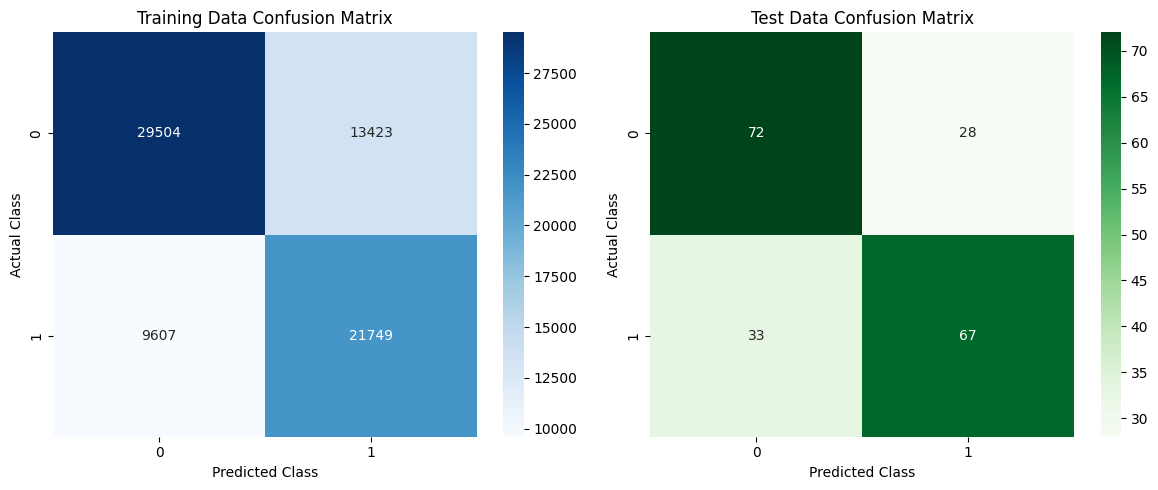

In [85]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions as before
y_train_pred = (model.predict(X_train) >= 0.5).astype(int)
y_test_pred  = (model.predict(X_test) >= 0.5).astype(int)

# Compute the confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test  = confusion_matrix(y_test,  y_test_pred)

# Print the confusion matrices
print("------- CONFUSION MATRICES FOR FINAL MODEL -------")
print("Confusion Matrix (TRAINING DATA):")
print(cm_train)
print("\nConfusion Matrix (TEST DATA):")
print(cm_test)
print("\n------- Confusion Matrix Layout -------")
print(" Rows: Actual Class [0, 1]")
print(" Cols: Predicted Class [0, 1]")

# Visualize using Seaborn heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training data confusion matrix
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Training Data Confusion Matrix")
axes[0].set_xlabel("Predicted Class")
axes[0].set_ylabel("Actual Class")

# Test data confusion matrix
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Test Data Confusion Matrix")
axes[1].set_xlabel("Predicted Class")
axes[1].set_ylabel("Actual Class")

plt.tight_layout()
plt.show()
